On perlmutter: use kernel pytorch-1.13.1

In [1]:
!pip install nflows
#pip install wandb
!pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


import os
import torch


from numba import cuda 

from helpers.make_flow import *
from helpers.train_flow import *
from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *
from helpers.evaluation import *

seed = 8

In [3]:
# computing

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


SBL data has shape (332348, 7).
IBL data has shape (36411, 7).
SR data has shape (45818, 7).
IBH data has shape (14290, 7).
SBH data has shape (63023, 7).


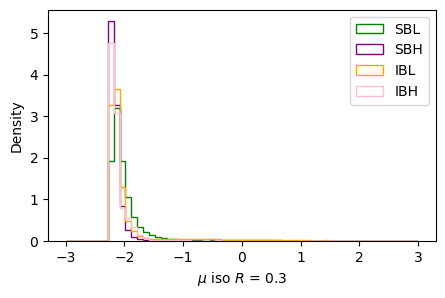

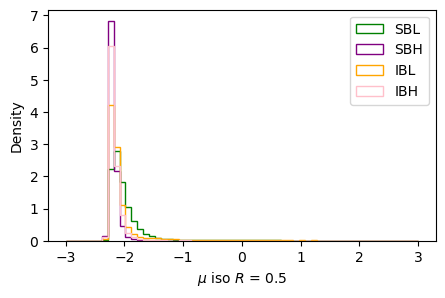

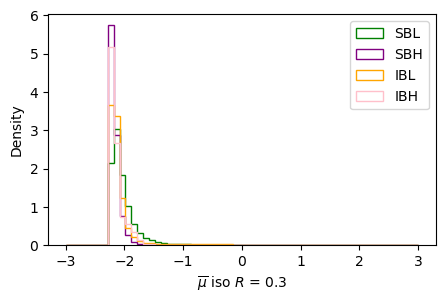

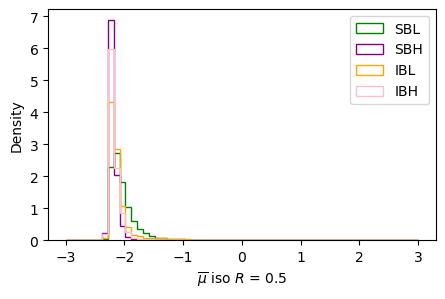

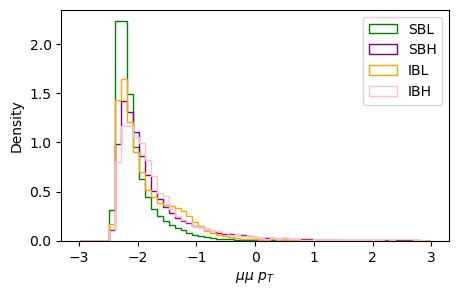

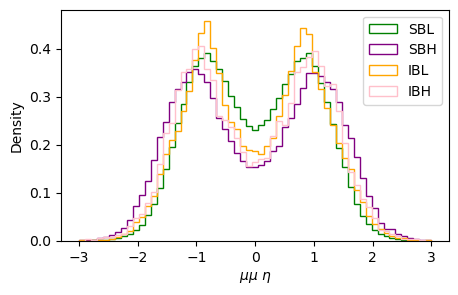

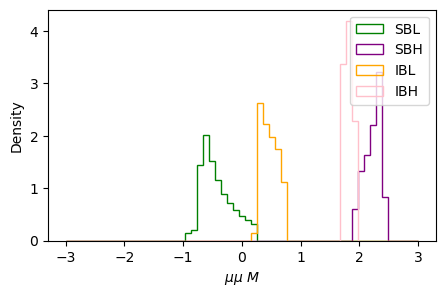

In [4]:
# load in the data

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]
data_dict = {}

feature_set = [5, 6, 7, 8, 9, 10, 12]
num_features = len(feature_set) - 1 # context doesn't count

for b in bands:

    data_dict[b] = np.load(f"processed_data/cmssim_{b}.npy")[:,feature_set]
    print("{b} data has shape {length}.".format(b = b, length = data_dict[b].shape))


data_dict["SB"] =  np.vstack((data_dict["SBL"], data_dict["SBH"]))
data_dict["IB"] =  np.vstack((data_dict["IBL"], data_dict["IBH"]))


hist_all_features(["SBL", "SBH", "IBL", "IBH"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, image_path = "plots/procc_data")


In [5]:
# train val test split
from sklearn.model_selection import train_test_split

SBL_data_train, SBL_data_val = train_test_split(data_dict["SBL"], test_size=0.2, random_state=42)
SBH_data_train, SBH_data_val = train_test_split(data_dict["SBH"], test_size=0.2, random_state=42)



print(f"SBL train data has shape {SBL_data_train.shape}.")
print(f"SBL val data has shape {SBL_data_val.shape}.")
print(f"SBH train data has shape {SBH_data_train.shape}.")
print(f"SBH val data has shape {SBH_data_val.shape}.")



SBL train data has shape (265878, 7).
SBL val data has shape (66470, 7).
SBH train data has shape (50418, 7).
SBH val data has shape (12605, 7).


## Flow creation and training

In [6]:
# Create the flow

# This will be the upper subdirectory in saved_models/

num_layers = 4
num_hidden_features = 16
num_blocks = 8
hyperparameters_dict = {"n_epochs":50,
                          "batch_size": 512,
                          "lr": 0.0005,
                          "weight_decay": 0.001}


flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_hidden_features}hidden_{num_blocks}blocks_{seed}seed"

flow_training_dir = os.path.join("models", f"{flow_training_id}/")
os.makedirs(flow_training_dir, exist_ok=True)




test_flow = make_masked_AR_flow(num_features, num_layers, num_hidden_features, num_blocks)

pytorch_total_params = sum(p.numel() for p in test_flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")

Numb. trainable params: 30840


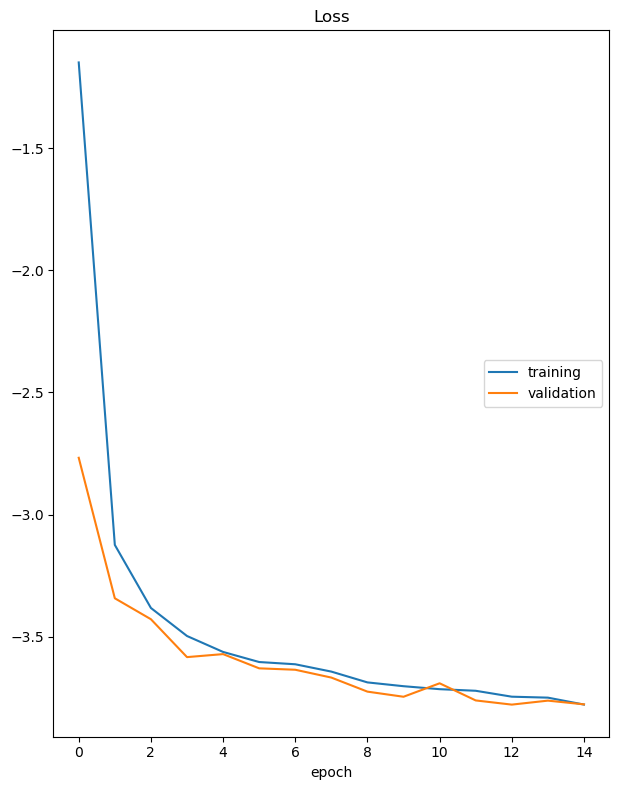

 30%|███       | 15/50 [10:17<24:00, 41.16s/it]

Loss
	training         	 (min:   -3.778, max:   -1.149, cur:   -3.778)
	validation       	 (min:   -3.778, max:   -2.768, cur:   -3.777)


In [ ]:

epochs, losses, losses_val, best_epoch = train_flow_asymm_SB(test_flow, hyperparameters_dict, device, 
                                                    SBL_data_train, SBL_data_val, SBH_data_train, SBH_data_val,
                                                             flow_training_dir, seed = seed)


In [ ]:
plt.figure()
plt.plot(epochs, losses, label = "loss")
plt.plot(epochs, losses_val, label = "val loss")
plt.legend()
plt.show()

print(best_epoch)

## Evaluate the SB Samples

In [ ]:
# Load in model
config_string = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict["n_epochs"], hyperparameters_dict["lr"], hyperparameters_dict["weight_decay"], hyperparameters_dict["batch_size"])
checkpoint_path = os.path.join(flow_training_dir, f"{config_string}_best_model.pt")
    

data_dict["SBL_samples"] = sample_from_flow(checkpoint_path, device, data_dict["SBL"][:,-1], num_features)
data_dict["SBH_samples"] = sample_from_flow(checkpoint_path, device, data_dict["SBH"][:,-1], num_features)
data_dict["SB_samples"] =  np.vstack((data_dict["SBL_samples"], data_dict["SBH_samples"]))



In [ ]:
hist_all_features(["SBL", "SBL_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, plot_bound = 5, yscale_log = True, image_path = "plots/low_SB")
hist_all_features(["SBH", "SBH_samples"], data_dict, feature_set, kwargs_dict_bands, scaled_features = True, plot_bound = 5, yscale_log = True, image_path = "plots/high_SB")

wds = get_1d_wasserstein_distances(data_dict["SB"], data_dict["SB_samples"])

for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")

In [ ]:
# Train a BC to discrim SB data from SB samples

"""
hyperparameters_dict_BC = {"n_epochs":100,
                          "batch_size": 512,
                          "lr": 0.001,
                         }

SB_data_train, SB_data_test, SB_samples_train, SB_samples_test = train_test_split(data_dict["SB"], data_dict["SB_samples"], 
                                                                                  test_size=0.1, random_state=42)

#print(f"SB data train has shape {SB_data_train.shape}.")
#print(f"SB data test has shape {SB_data_test.shape}.")
#print(f"SB samples train has shape {SB_samples_train.shape}.")
#print(f"SB samples test has shape {SB_samples_test.shape}.")

n_runs = 3
auc_list = []


for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, SB_data_train[:,:-1],  SB_samples_train[:,:-1], 
                                np.ones((SB_data_train.shape[0],1)), np.ones((SB_samples_train.shape[0],1)), 
                                   SB_data_test[:,:-1], SB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)

print(np.mean(auc_list), np.std(auc_list))

print(auc_list)

"""

## Test the inner bands

In [ ]:

data_dict["IBL_samples"] = sample_from_flow(checkpoint_path, device, data_dict["IBL"][:,-1], num_features)
data_dict["IBH_samples"] = sample_from_flow(checkpoint_path, device, data_dict["IBH"][:,-1], num_features)
data_dict["IB_samples"] =  np.vstack((data_dict["IBL_samples"], data_dict["IBH_samples"]))


print(data_dict["IBL_samples"].shape)
print(data_dict["IBH_samples"].shape)

In [ ]:
hist_all_features(["IBL", "IBL_samples"], data_dict, feature_set, kwargs_dict_bands, yscale_log = True, plot_bound = 5, scaled_features = True, image_path = "plots/low_IB")
hist_all_features(["IBH", "IBH_samples"], data_dict, feature_set, kwargs_dict_bands, yscale_log = True, plot_bound = 5, scaled_features = True, image_path = "plots/high_IB")

wds = get_1d_wasserstein_distances(data_dict["IB"], data_dict["IB_samples"])

for i, wd in enumerate(wds):
    print(f"Feature {i} distance: {wd}")
print(f"Total distance: {np.mean(wds)}")

In [ ]:
"""
IB_data_train, IB_data_test, IB_samples_train, IB_samples_test = train_test_split(data_dict["IB"], data_dict["IB_samples"], 
                                                                                  test_size=0.1, random_state=42)

#print(f"IB data train has shape {IB_data_train.shape}.")
#print(f"IB data test has shape {IB_data_test.shape}.")
#print(f"IB samples train has shape {IB_samples_train.shape}.")
#print(f"IB samples test has shape {IB_samples_test.shape}.")

n_runs = 3
auc_list = []

for i in range(n_runs):


    auc, fpr, tpr, outputs = discriminate_datasets_kfold(flow_training_dir, IB_data_train[:,:-1],  IB_samples_train[:,:-1], 
                                np.ones((IB_data_train.shape[0],1)), np.ones((IB_samples_train.shape[0],1)), 
                                   IB_data_test[:,:-1], IB_samples_test[:,:-1], 
                                num_features, hyperparameters_dict_BC, device, seed = i, visualize = False, k_folds = 2)


    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(fpr, tpr)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title("ROC: " + str(auc))
    
    auc_list.append(auc)


print(np.mean(auc_list), np.std(auc_list))

print(auc_list)

"""